In [1]:
### This script is for calculating FDR values using control (non-expressed gene result)
# This script fit kernel density curve to cdf of  p-val distribution
rm(list=ls())
library(sROC)
library(ggplot2)
require(gridExtra)
library(dplyr)

Warning message:
"package 'sROC' was built under R version 3.6.3"sROC 0.1-2 loaded
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: gridExtra

Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
#-----Read file-----
dir.out.fig4 = './figure4/'

In [3]:
# Parameters for reading file
feature_type = 'histology'; run = 'cohort_new_newcova_nohypermutator'; threshold = 1;
df.all.feat = read.csv(file.path(dir.out.fig4,paste0(feature_type,'.syn.df_all_forFDR.',
                                                run,'.csv')),sep = ',')

In [4]:
# organize and get p-values for all, expressed , nonexpressed and only significant ones
df.all.feat = df.all.feat[order(df.all.feat$p),]
df.exp.feat = df.all.feat[df.all.feat$exp.nonexp =='exp',] ; 
df.ne.feat = df.all.feat[df.all.feat$exp.nonexp =='nonexp',]
df.sig.feat = na.omit(df.all.feat[df.all.feat$p<0.05,])
x.sig.exp = na.omit(df.sig.feat$p)
x.all = na.omit(df.all.feat$p)
x.ne = na.omit(df.ne.feat$p)

In [5]:
#-----Run the kernel estimated CDF function for CDF plot-----
bandwidth = 0.00001
### 1. For visualizing the entire CDF -- xgrid is default equally spaced points
res.ne.cdf = kCDF(x.ne, bw = bandwidth, kernel = 'normal')
res.all.cdf = kCDF(x.all,bw = bandwidth, kernel = 'normal')
# Dataframes for plots
x.ne.cdf = res.ne.cdf[["x"]]; y.ne.cdf  = res.ne.cdf$Fhat; df.ne.cdf = data.frame(x.ne.cdf , y.ne.cdf)
x.all.cdf = res.all.cdf[["x"]]; y.all.cdf = res.all.cdf$Fhat;df.all.cdf = data.frame(x.all.cdf, y.all.cdf)

### 2. For visualizing the entire CDF -- ECDF from step functions
all.step = ecdf(x.all);ne.step = ecdf(x.ne)
df.all.step = data.frame(x.all, all.step(x.all))
df.ne.step = data.frame(x.ne, all.step(x.ne))

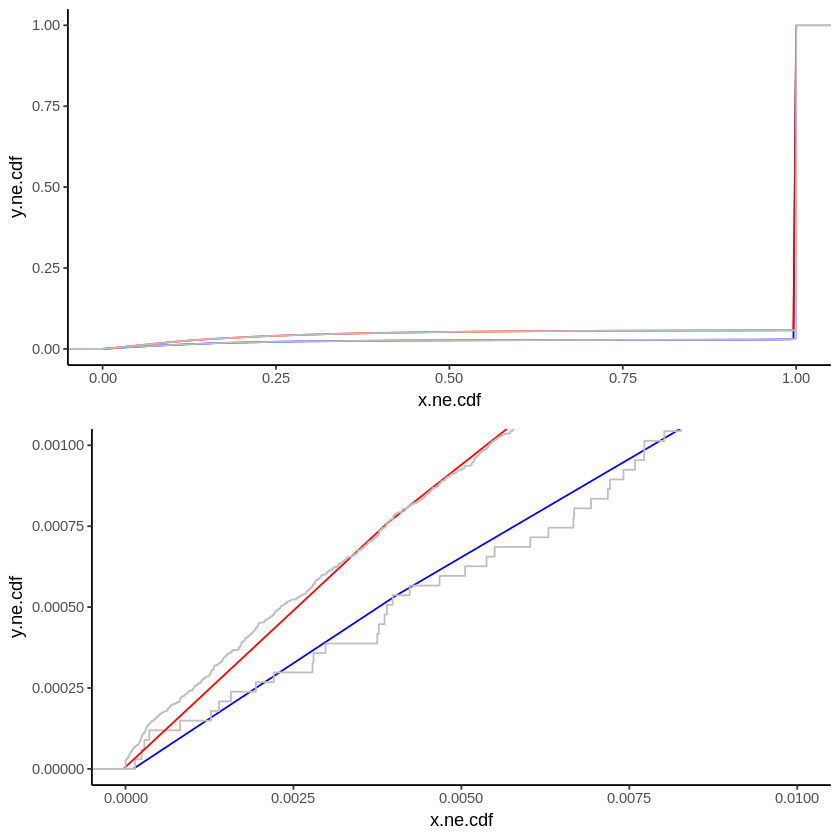

In [6]:
#-----Plot the step CDF and the estimated CDF-----
# The whole CDF
p = ggplot() + 
  # nonexpressed (h0) CDF and step functions
  geom_line(data = df.ne.cdf, aes(x = x.ne.cdf, y = y.ne.cdf), color = "blue") +
  stat_ecdf(data = df.ne.step, aes(x.ne),geom = 'step', color = 'grey')+
  # All gene CDF and step functions
  geom_line(data = df.all.cdf, aes(x = x.all.cdf, y = y.all.cdf), color = "red")+
  stat_ecdf(data = df.all.step, aes(x.all),geom = 'step', color = 'grey')+
  theme_classic()
  # Zoom in axis
#  coord_cartesian(xlim=c(-0.01,0.005), ylim = c(0,0.0005))
p2 = ggplot() + 
  # nonexpressed (h0) CDF and step functions
  geom_line(data = df.ne.cdf, aes(x = x.ne.cdf, y = y.ne.cdf), color = "blue") +
  stat_ecdf(data = df.ne.step, aes(x.ne),geom = 'step', color = 'grey')+
  # All gene CDF and step functions
  geom_line(data = df.all.cdf, aes(x = x.all.cdf, y = y.all.cdf), color = "red")+
  stat_ecdf(data = df.all.step, aes(x.all),geom = 'step', color = 'grey')+
  theme_classic()+
# Zoom in axis
  coord_cartesian(xlim=c(0,0.01), ylim = c(0,0.001))

grid.arrange(p, p2, nrow=2)

In [7]:
#-----Calculate the Bayesian FDR value-----
### For estimating the Fhat of observed p-values
bandwidth = 0.00001
res.ne.est = kCDF(x.ne, xgrid = x.sig.exp, bw = bandwidth)
res.all.est = kCDF(x.all, xgrid = x.sig.exp, bw = bandwidth)

# Calculate Bayesian FDR
proba.h0 = 0.99
for(i in 1:(nrow(df.sig.feat))){
  x = df.sig.feat$p[i] # observed p-value
  denom = res.all.est[["Fhat"]][i] # Denominator = p(x) 
  proba.FP.x = res.ne.est[["Fhat"]][i]
  numer = proba.h0*proba.FP.x # Numerator = P(H0,x)
  proba.x.FP = numer/denom
  df.sig.feat$FDR[i] = proba.x.FP}

In [10]:
df.sig.feat[df.sig.feat$FDR<0.1,]

,X,gene,p,q,feature,exp.nonexp,FDR
1,0,BCL2,0.000000e+00,0.00000000,Lymph-BNHL,exp,8.984726e-47
2,1,PCDHA4,0.000000e+00,0.00000000,Lymph-BNHL,exp,8.984726e-47
3,2,SRSF2,0.000000e+00,0.00000000,Lymph-BNHL,exp,8.984726e-47
52771,52770,ITLN1,0.000000e+00,0.00000000,CNS-PiloAstro,exp,8.984726e-47
211081,211080,ACTA1,0.000000e+00,0.00000000,Lymph-CLL,exp,8.984726e-47
316621,316620,PCDHA7,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
316622,316621,PCDHA8,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
316623,316622,PCDHGB6,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
316624,316623,SIGLEC15,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
316625,316624,TP53I3,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47


In [29]:
df.res.sig <- dplyr::filter(df.sig.feat, !grepl("^PCDH", gene))
df.res.sig = df.res.sig[df.res.sig$FDR<0.1,]

In [30]:
df.res.sig

X,gene,p,q,feature,exp.nonexp,FDR
0,BCL2,0.000000e+00,0.00000000,Lymph-BNHL,exp,8.984726e-47
2,SRSF2,0.000000e+00,0.00000000,Lymph-BNHL,exp,8.984726e-47
52770,ITLN1,0.000000e+00,0.00000000,CNS-PiloAstro,exp,8.984726e-47
211080,ACTA1,0.000000e+00,0.00000000,Lymph-CLL,exp,8.984726e-47
316623,SIGLEC15,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
316624,TP53I3,0.000000e+00,0.00000000,Panc-AdenoCA,exp,8.984726e-47
351800,LONRF3,0.000000e+00,0.00000000,Liver-HCC,exp,8.984726e-47
351801,RTN4,0.000000e+00,0.00000000,Liver-HCC,exp,8.984726e-47
386980,PPWD1,0.000000e+00,0.00000000,Head-SCC,exp,8.984726e-47
527700,MAGEC1,0.000000e+00,0.00000000,Breast-AdenoCA,exp,8.984726e-47


In [31]:
# fig = arrangeGrob(p2, p1, ncol=2)
# saveRDS(res,file.path(dir.out.func,'fdr.063021.rds'))
fname = paste0(feature_type,'.syn.df_all_forheatmap.',
               run,'.csv')
write.csv(df.res.sig,file.path(dir.out.fig4, fname))
#ggsave(file=file.path(dir.out.fig,'fsdr.063021.png'), fig)